In [1]:
import numpy as np
import pandas as pd
import dataframe_image as dfi

In [2]:
df = pd.read_excel('Datasets_Ready.xlsx')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510 entries, 0 to 4509
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      4510 non-null   int64  
 1   Text            4510 non-null   object 
 2   emoji           4510 non-null   object 
 3   Tokenized       4510 non-null   object 
 4   final_text      4494 non-null   object 
 5   text_emoji      4510 non-null   object 
 6   Pos_Word        4510 non-null   int64  
 7   Neg_Word        4510 non-null   int64  
 8   Total_Word      4510 non-null   int64  
 9   Pos_Ratio       4510 non-null   float64
 10  Neg_Ratio       4510 non-null   float64
 11  Sentimen_Text   4510 non-null   object 
 12  Tokenize_Emoji  4510 non-null   object 
 13  Pos_Emoji       4510 non-null   int64  
 14  Neg_Emoji       4510 non-null   int64  
 15  Sentimen_Emoji  4510 non-null   object 
 16  Sarcasm         4510 non-null   object 
dtypes: float64(2), int64(6), object(9

,Unnamed: 0,Text,emoji,Tokenized,final_text,text_emoji,Pos_Word,Neg_Word,Total_Word,Pos_Ratio,Neg_Ratio,Sentimen_Text,Tokenize_Emoji,Pos_Emoji,Neg_Emoji,Sentimen_Emoji,Sarcasm
0,0,kawan2 sunda bersatu jemput arteria dahlan,😁,"['kawan', 'sunda', 'bersatu', 'jemput', 'arter...",kawan sunda bersatu jemput arteria dahlan,kawan sunda bersatu jemput arteria dahlan 😁,2,0,6,0.333333,0.000000,Positif,"['kawan', 'sunda', 'bersatu', 'jemput', 'arter...",1,0,Positif,Negatif
1,2,arteria dahlan disidang adat sunda daerah menu...,😁,"['arteria', 'dahlan', 'sidang', 'adat', 'sunda...",arteria dahlan sidang adat sunda daerah menunt...,arteria dahlan sidang adat sunda daerah menunt...,5,4,9,0.555556,0.444444,Positif,"['arteria', 'dahlan', 'sidang', 'adat', 'sunda...",1,0,Positif,Negatif
2,4,ga ditafsirkan membanding bandingkan edy arter...,😁,"['ga', 'tafsir', 'membanding', 'membandingkan'...",ga tafsir membanding membandingkan edy arteria...,ga tafsir membanding membandingkan edy arteria...,3,2,9,0.333333,0.222222,Positif,"['ga', 'tafsir', 'membanding', 'membandingkan'...",1,0,Positif,Negatif
3,5,nantik ngak divhumas polri nya bilang palsu td...,😁,"['nanti', 'tidak', 'divisi humas', 'polri', '....",divisi humas polri bilang palsu mengeluarkan a...,divisi humas polri bilang palsu mengeluarkan a...,4,8,16,0.250000,0.500000,Negatif,"['divisi', 'humas', 'polri', 'bilang', 'palsu'...",1,0,Positif,Positif
4,6,urut dada dech kuasa hukum tdk mengerti hukum ...,😁,"['urut', 'dada', 'deh', 'kuasa', 'hukum', 'tid...",urut dada deh kuasa hukum mengerti hukum arter...,urut dada deh kuasa hukum mengerti hukum arter...,14,6,28,0.500000,0.214286,Positif,"['urut', 'dada', 'deh', 'kuasa', 'hukum', 'men...",1,0,Positif,Negatif


In [3]:
# Remove unused column/feature
df = df.drop(columns='Unnamed: 0')
df = df.drop(columns='Text')
df = df.drop(columns='emoji')
df = df.drop(columns='Tokenized')
df = df.drop(columns='final_text')
df = df.drop(columns='Pos_Word')
df = df.drop(columns='Neg_Word')
df = df.drop(columns='Total_Word')
df = df.drop(columns='Pos_Ratio')
df = df.drop(columns='Neg_Ratio')
df = df.drop(columns='Tokenize_Emoji')
df = df.drop(columns='Pos_Emoji')
df = df.drop(columns='Neg_Emoji')
df = df.drop(columns='Sentimen_Emoji')

In [4]:
df.head()

,text_emoji,Sentimen_Text,Sarcasm
0,kawan sunda bersatu jemput arteria dahlan 😁,Positif,Negatif
1,arteria dahlan sidang adat sunda daerah menunt...,Positif,Negatif
2,ga tafsir membanding membandingkan edy arteria...,Positif,Negatif
3,divisi humas polri bilang palsu mengeluarkan a...,Negatif,Positif
4,urut dada deh kuasa hukum mengerti hukum arter...,Positif,Negatif


<h1>Feature Extraction Using GloVe Method</h1>

In [5]:
class GloVe:
    # constructors
    def __init__(self, corpus, embedding_size=100, window_size=5):
        self.corpus = corpus
        self.embedding_size = embedding_size
        self.window_size = window_size
        self.word2id = {}
        self.id2word = {}
        self.word2count = {}
        self.vocab_size = 0
        self.co_matrix = None
        self.embedding = None
        self.bias = None

    def build_vocab_information(self):
        for sentence in self.corpus:
            for word in sentence.split():
                if word not in self.word2id:
                    self.word2id[word] = self.vocab_size
                    self.id2word[self.vocab_size] = word
                    self.vocab_size += 1
                self.word2count[word] = self.word2count.get(word, 0) + 1

    def build_co_matrix(self):
        self.co_matrix = np.zeros((self.vocab_size, self.vocab_size))
        for sentence in self.corpus:
            sentence = sentence.split()
            for i, center_word in enumerate(sentence):
                for j in range(max(0, i - self.window_size), i):
                    context_word = sentence[j]
                    self.co_matrix[self.word2id[center_word]][self.word2id[context_word]] += 1
                    self.co_matrix[self.word2id[context_word]][self.word2id[center_word]] += 1

    def train(self, num_epochs=30, learning_rate=0.01):
        self.embedding = (np.random.rand(self.vocab_size, self.embedding_size) - 0.5) / self.embedding_size
        self.bias = np.zeros(self.vocab_size)

        for epoch in range(num_epochs):
            loss = 0
            for i in range(self.vocab_size):
                for j in range(self.vocab_size):
                    if self.co_matrix[i][j] != 0:
                        diff = (self.embedding[i] @ self.embedding[j]) + self.bias[i] + self.bias[j] - np.log(self.co_matrix[i][j])
                        loss += diff ** 2

                        grad_emb_i = diff * self.embedding[j]
                        grad_emb_j = diff * self.embedding[i]
                        grad_bias_i = diff
                        grad_bias_j = diff

                        self.embedding[i] -= learning_rate * grad_emb_i
                        self.embedding[j] -= learning_rate * grad_emb_j
                        self.bias[i] -= learning_rate * grad_bias_i
                        self.bias[j] -= learning_rate * grad_bias_j

            print(f'Epoch {epoch + 1}/{num_epochs} - loss {round(loss, 3)}')
            
            if loss <= 0.001:
                print('Training Stopped, loss less than equal 0.001')
                break

    def get_all_embeddings(self):
        all_embeddings = {}
        for word, word_id in self.word2id.items():
            all_embeddings[word] = self.embedding[word_id]
        return all_embeddings
    
    def get_embeddings_by_id(self, id):
        return self.embedding[id]
    
    def get_embeddings(self, kata):
        word_embeddings = {}
        for word, word_id in self.word2id.items():
            if word == kata:
                word_embeddings[word] = self.embedding[word_id]
        return word_embeddings

    def embedding2word(self):
        embedding_to_word = {}
        for word, word_id in self.word2id.items():
            embedding_to_word[tuple(self.embedding[word_id])] = word
        return embedding_to_word
    
    def get_glove_embedding(self, sentence):
        sentence = sentence.split()
        embedding_vectors = []
        for word in sentence:
            if word in self.word2id:
                word_id = self.word2id[word]
                word_embedding = self.embedding[word_id]
                embedding_vectors.append(word_embedding)
        return embedding_vectors
    
    def show_comatrix(self):
        # df_co_matrix = pd.DataFrame(self.co_matrix, index=self.word2id.keys(), columns=self.word2id.keys())
        
        return self.co_matrix
    
    def generate_coomatrix_image(self):
        df_co_matrix = pd.DataFrame(self.co_matrix, index=self.word2id.keys(), columns=self.word2id.keys())

        print('Image is being processed...')
        dfi.export(df_co_matrix.head(10), "coocurrenceMatrix.png", max_cols=10)
        
        return print('Coocurrence matrix has been successfully generated into an image')
    
    def show_word2id(self):
        return self.word2id
    
    def show_id2word(self):
        return self.id2word
    
    def show_word2count(self):
        return self.word2count

In [6]:
# Membangun model GloVe
glove_model = GloVe(df['text_emoji'])

# Membangun vocabulary
glove_model.build_vocab_information()

# Membangun co-occurrence matrix
glove_model.build_co_matrix()

# Melatih model GloVe
glove_model.train()

Epoch 1/30 - loss 50648.622
Epoch 2/30 - loss 46808.16
Epoch 3/30 - loss 45914.078
Epoch 4/30 - loss 44610.09
Epoch 5/30 - loss 41261.808
Epoch 6/30 - loss 38708.756
Epoch 7/30 - loss 37188.327
Epoch 8/30 - loss 35326.757
Epoch 9/30 - loss 33366.635
Epoch 10/30 - loss 31621.98
Epoch 11/30 - loss 30072.766
Epoch 12/30 - loss 28588.523
Epoch 13/30 - loss 27114.637
Epoch 14/30 - loss 25635.061
Epoch 15/30 - loss 24152.082
Epoch 16/30 - loss 22688.83
Epoch 17/30 - loss 21270.806
Epoch 18/30 - loss 19921.428
Epoch 19/30 - loss 18661.501
Epoch 20/30 - loss 17502.666
Epoch 21/30 - loss 16445.306
Epoch 22/30 - loss 15482.952
Epoch 23/30 - loss 14606.912
Epoch 24/30 - loss 13808.399
Epoch 25/30 - loss 13079.224
Epoch 26/30 - loss 12412.082
Epoch 27/30 - loss 11800.674
Epoch 28/30 - loss 11239.639
Epoch 29/30 - loss 10724.383
Epoch 30/30 - loss 10250.883


In [7]:
# Menampilkan Dict word2id
word_2_id = glove_model.show_word2id()
word_2_id

{'kawan': 0,
 'sunda': 1,
 'bersatu': 2,
 'jemput': 3,
 'arteria': 4,
 'dahlan': 5,
 '😁': 6,
 'sidang': 7,
 'adat': 8,
 'daerah': 9,
 'menuntut': 10,
 'hukum': 11,
 'ga': 12,
 'tafsir': 13,
 'membanding': 14,
 'membandingkan': 15,
 'edy': 16,
 'menegakkan': 17,
 'divisi': 18,
 'humas': 19,
 'polri': 20,
 'bilang': 21,
 'palsu': 22,
 'mengeluarkan': 23,
 'membenarkan': 24,
 'plat': 25,
 'no': 26,
 'asli': 27,
 'urut': 28,
 'dada': 29,
 'deh': 30,
 'kuasa': 31,
 'mengerti': 32,
 'tsb': 33,
 'dengar': 34,
 'pendapat': 35,
 'gedung': 36,
 'dpr': 37,
 'memiliki': 38,
 'kekebalan': 39,
 'atur': 40,
 'konstitusi': 41,
 'n': 42,
 'uu': 43,
 'maaf': 44,
 'memaafkan': 45,
 'kubu': 46,
 'saran': 47,
 'dorong': 48,
 'masyarakat': 49,
 'jabar': 50,
 'menangkap': 51,
 'semoga': 52,
 'berpegang': 53,
 'komitmen': 54,
 'menenggelamkan': 55,
 'partai': 56,
 'demokrasi': 57,
 'indonesia': 58,
 'perjuangan': 59,
 'spt': 60,
 'sumbar': 61,
 'beruntung': 62,
 'kabar': 63,
 'e': 64,
 'hina': 65,
 'suku': 66

In [8]:
# Menampilkan Dict id2word
id_2_word = glove_model.show_id2word()
id_2_word

{0: 'kawan',
 1: 'sunda',
 2: 'bersatu',
 3: 'jemput',
 4: 'arteria',
 5: 'dahlan',
 6: '😁',
 7: 'sidang',
 8: 'adat',
 9: 'daerah',
 10: 'menuntut',
 11: 'hukum',
 12: 'ga',
 13: 'tafsir',
 14: 'membanding',
 15: 'membandingkan',
 16: 'edy',
 17: 'menegakkan',
 18: 'divisi',
 19: 'humas',
 20: 'polri',
 21: 'bilang',
 22: 'palsu',
 23: 'mengeluarkan',
 24: 'membenarkan',
 25: 'plat',
 26: 'no',
 27: 'asli',
 28: 'urut',
 29: 'dada',
 30: 'deh',
 31: 'kuasa',
 32: 'mengerti',
 33: 'tsb',
 34: 'dengar',
 35: 'pendapat',
 36: 'gedung',
 37: 'dpr',
 38: 'memiliki',
 39: 'kekebalan',
 40: 'atur',
 41: 'konstitusi',
 42: 'n',
 43: 'uu',
 44: 'maaf',
 45: 'memaafkan',
 46: 'kubu',
 47: 'saran',
 48: 'dorong',
 49: 'masyarakat',
 50: 'jabar',
 51: 'menangkap',
 52: 'semoga',
 53: 'berpegang',
 54: 'komitmen',
 55: 'menenggelamkan',
 56: 'partai',
 57: 'demokrasi',
 58: 'indonesia',
 59: 'perjuangan',
 60: 'spt',
 61: 'sumbar',
 62: 'beruntung',
 63: 'kabar',
 64: 'e',
 65: 'hina',
 66: 'suku'

In [9]:
# Menampilkan Dict word2count
word_2_count = glove_model.show_word2count()
word_2_count

{'kawan': 40,
 'sunda': 19,
 'bersatu': 14,
 'jemput': 7,
 'arteria': 35,
 'dahlan': 31,
 '😁': 501,
 'sidang': 4,
 'adat': 18,
 'daerah': 46,
 'menuntut': 6,
 'hukum': 57,
 'ga': 187,
 'tafsir': 2,
 'membanding': 1,
 'membandingkan': 12,
 'edy': 29,
 'menegakkan': 8,
 'divisi': 1,
 'humas': 1,
 'polri': 9,
 'bilang': 63,
 'palsu': 10,
 'mengeluarkan': 4,
 'membenarkan': 4,
 'plat': 4,
 'no': 16,
 'asli': 38,
 'urut': 1,
 'dada': 2,
 'deh': 32,
 'kuasa': 9,
 'mengerti': 10,
 'tsb': 19,
 'dengar': 12,
 'pendapat': 9,
 'gedung': 5,
 'dpr': 68,
 'memiliki': 53,
 'kekebalan': 1,
 'atur': 15,
 'konstitusi': 11,
 'n': 47,
 'uu': 16,
 'maaf': 67,
 'memaafkan': 5,
 'kubu': 38,
 'saran': 7,
 'dorong': 2,
 'masyarakat': 171,
 'jabar': 6,
 'menangkap': 3,
 'semoga': 207,
 'berpegang': 2,
 'komitmen': 22,
 'menenggelamkan': 3,
 'partai': 333,
 'demokrasi': 133,
 'indonesia': 490,
 'perjuangan': 125,
 'spt': 24,
 'sumbar': 1,
 'beruntung': 14,
 'kabar': 17,
 'e': 24,
 'hina': 13,
 'suku': 10,
 'peja

In [10]:
# Menampilkan hasil dari Cooccurence Matrix
co_matrix = glove_model.show_comatrix()

co_matrix

array([[14.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [11]:
# # Generate image Matrix Coocurrence
# generateCooMatrix = glove_model.generate_coomatrix_image()

# generateCooMatrix

Image is being processed...
Coocurrence matrix has been successfully generated into an image


In [13]:
word_embeddings = glove_model.get_embeddings('😁')

print(word_embeddings)

{'😁': array([ 0.23494744,  0.12520461, -0.22727871, -0.27391449, -0.05901351,
        0.40780827, -0.02626195, -0.15656603, -0.4169597 , -0.38411058,
       -0.22773592,  0.03940908,  0.55770933,  0.11215147,  0.00252058,
        0.08587648, -0.06969752,  0.44955972, -0.02625886, -0.5230726 ,
       -0.54874625, -0.22787711, -0.0094924 ,  0.09996657,  0.67124965,
        0.31597251,  0.11106687, -0.16285733, -0.02500625, -0.02874576,
       -0.02976311,  0.0042004 , -0.07019538, -0.29078134,  0.12384447,
        0.18488665,  0.32521894, -0.35940445, -0.06998437, -0.01861419,
       -0.07932197, -0.18381344,  0.30792988, -0.16577859, -0.06731961,
        0.25193877, -0.45026332, -0.13852657,  0.19913117, -0.45236757,
        0.65504947,  0.08790216, -0.22073306, -0.50287228, -0.22984082,
        0.29247632, -0.13354634, -0.21471936,  0.10595713,  0.14419886,
        0.63334252, -0.15455871, -0.09327541,  0.33798551,  0.02206383,
        0.34429956, -0.4193449 , -0.08940015, -0.03260597,

In [14]:
embedding_by_id = glove_model.get_embeddings_by_id(6)

embedding_by_id

array([ 0.23494744,  0.12520461, -0.22727871, -0.27391449, -0.05901351,
        0.40780827, -0.02626195, -0.15656603, -0.4169597 , -0.38411058,
       -0.22773592,  0.03940908,  0.55770933,  0.11215147,  0.00252058,
        0.08587648, -0.06969752,  0.44955972, -0.02625886, -0.5230726 ,
       -0.54874625, -0.22787711, -0.0094924 ,  0.09996657,  0.67124965,
        0.31597251,  0.11106687, -0.16285733, -0.02500625, -0.02874576,
       -0.02976311,  0.0042004 , -0.07019538, -0.29078134,  0.12384447,
        0.18488665,  0.32521894, -0.35940445, -0.06998437, -0.01861419,
       -0.07932197, -0.18381344,  0.30792988, -0.16577859, -0.06731961,
        0.25193877, -0.45026332, -0.13852657,  0.19913117, -0.45236757,
        0.65504947,  0.08790216, -0.22073306, -0.50287228, -0.22984082,
        0.29247632, -0.13354634, -0.21471936,  0.10595713,  0.14419886,
        0.63334252, -0.15455871, -0.09327541,  0.33798551,  0.02206383,
        0.34429956, -0.4193449 , -0.08940015, -0.03260597,  0.06

In [19]:
all_embedding = glove_model.get_all_embeddings()

len(all_embedding)

6769

In [17]:
# # Mendapatkan semua embedding
# embeddings = glove_model.get_all_embeddings()

# # Menyimpan embedding ke file teks
# output_file = "embeddings.txt"
# with open(output_file, "w", encoding="utf-8") as file:
#     for word, embedding in embeddings.items():
#         embedding_line = "{} {}\n".format(word, " ".join(str(value) for value in embedding))
#         file.write(embedding_line)

# print("Embedding telah disimpan ke file: {}".format(output_file))

Embedding telah disimpan ke file: embeddings.txt


<h1>Create New Feature for Word Embeddings</h1>

In [ ]:
# df_ready['embedding'] = df_ready['text_emoji'].apply(lambda x: glove_model.get_glove_embedding(x))

In [ ]:
# df_ready.head()

<h2>Fungsi untuk merubah token menjadi representasi word embedding</h2>

In [ ]:
# def replace_token_with_word_embedding(token, word_embedding):
#     embeddings = []
#     for word in token:
#         if word in word_embedding:
#             embeddings.append(word_embedding[word])
    
#     return np.array(embeddings)

In [ ]:
# df_ready['text_emoji'] = df_ready['text_emoji'].apply(replace_token_with_word_embedding, word_embedding=word_embeddings)

In [ ]:
# df_ready.head()

In [ ]:
# df_ready['text_emoji'].duplicated().sum()

In [ ]:
# df_ready.head()

In [ ]:
# df_ready['text_emoji'][0]

In [ ]:
# embedding2word = glove_model.embedding2word()

# embedding2word[tuple(df_ready['text_emoji'][0][0])]

<h1>Implement SMOTE</h1>

In [20]:
df['Sentimen_Text'] = df['Sentimen_Text'].replace('Positif', 1)
df['Sentimen_Text'] = df['Sentimen_Text'].replace('Negatif', 0)

df['Sarcasm'] = df['Sarcasm'].replace('Positif', 1)
df['Sarcasm'] = df['Sarcasm'].replace('Negatif', 0)

In [22]:
# Cek class minoritas
df['Sarcasm'].value_counts()

0    2297
1    2213
Name: Sarcasm, dtype: int64

<p>Terlihat Bahwa class minoritas adalah class dengan nilai 1(Positif)</p>

In [23]:
max_len = 50
len_voc = 40000

In [24]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=42, shuffle=False)

In [25]:
df_train_min = df_train[df_train['Sarcasm'] == 1]
df_train_maj = df_train[df_train['Sarcasm'] == 0]

df_test_min = df_test[df_test['Sarcasm'] == 1]
df_test_maj = df_test[df_test['Sarcasm'] == 0]

In [26]:
df_train_min

,text_emoji,Sentimen_Text,Sarcasm
3,divisi humas polri bilang palsu mengeluarkan a...,0,1
8,pejabat sakit jiwa menantang goblok pejabat ra...,0,1
9,pasteur bandung arteria dahlan mulut busuk 😁,0,1
10,acara resmi pakai bahasa indonesia tp penyelen...,0,1
14,arteria dahlan maaf memperbaiki partai demokra...,0,1
...,...,...,...
3128,bagus publik mas paham teriak spt sang bupati ...,0,1
3136,wow luhut binsar rakus habis pemakan bumi pemi...,0,1
3147,jokowi centeng china luhut binsar wajib penjar...,0,1
3149,heboh pangkat tituler pangkat brigjen tituler ...,0,1


In [27]:
df_train_maj

,text_emoji,Sentimen_Text,Sarcasm
0,kawan sunda bersatu jemput arteria dahlan 😁,1,0
1,arteria dahlan sidang adat sunda daerah menunt...,1,0
2,ga tafsir membanding membandingkan edy arteria...,1,0
4,urut dada deh kuasa hukum mengerti hukum arter...,1,0
5,arteria dahlan maaf memaafkan kubu maaf saran ...,1,0
...,...,...,...
3151,menggantikan bp jokowi visi misi beliau ekonom...,1,0
3152,krn stok foto e sek sesepuh abadi sehat sukses...,1,0
3153,luhut binsar tinjau lokasi akad nikah titip pe...,1,0
3154,ri luhut binsar meninjau lokasi akad nikah pen...,1,0


In [28]:
df_test_min

,text_emoji,Sentimen_Text,Sarcasm
3158,detik antek asing ga mensukseskan cita cita lu...,0,1
3162,mas gibran 👍👍👍 👍,0,1
3163,sih mati babi luhut binsar antek cina komunis 💩,1,1
3164,uang mengatur negara on buka paman luhut binsar 💩,1,1
3165,menteri luhut buka suara isu penjualan kepulau...,1,1
...,...,...,...
4502,kebenaran 😭,1,1
4503,nih korupsi mentri partai partai demokrasi ind...,1,1
4505,😭,1,1
4507,ombak 😭,1,1


In [29]:
df_test_maj

,text_emoji,Sentimen_Text,Sarcasm
3157,menteri koordinator bidang kemaritiman investa...,1,0
3159,menteri luhut binsar memamerkan investasi asin...,1,0
3160,orang batak dukung paman luhut binsar 👍,1,0
3161,menteri partai golkar terpopuler berdasarkan p...,1,0
3170,berkuasa negeri gubernur provinsi 37 china dar...,0,0
...,...,...,...
4500,republik pencitraan 😭,0,0
4501,republik pencitraan nafsu lihat anies bobrok k...,0,0
4504,sia sia makna 😭,0,0
4506,gelandangan 😭,0,0


In [30]:
df_ready_min = pd.concat([df_train_min, df_test_min])
df_ready_maj = pd.concat([df_train_maj, df_test_maj])

In [31]:
# Tokenizing
def make_tokenizer(texts, len_voc):
    from keras.preprocessing.text import Tokenizer
    t = Tokenizer(num_words=len_voc)
    t.fit_on_texts(texts)
    return t

<h2>Tokenizer</h2>

In [32]:
tokenizer_min = make_tokenizer(df_ready_min['text_emoji'], len_voc)
tokenizer_maj = make_tokenizer(df_ready_maj['text_emoji'], len_voc)

<h2>Sequence</h2>

In [33]:
X_train_min = tokenizer_min.texts_to_sequences(df_train_min['text_emoji'])
X_test_min = tokenizer_min.texts_to_sequences(df_test_min['text_emoji'])
X_train_major = tokenizer_maj.texts_to_sequences(df_train_maj['text_emoji'])
X_test_major = tokenizer_maj.texts_to_sequences(df_test_maj['text_emoji'])

# X_train_Sentiment = df_train['Sentimen_Text']
# X_test_Sentiment = df_test['Sentimen_Text']

<h2>Padding</h2>

In [34]:
from keras.utils import pad_sequences

X_train_min = pad_sequences(X_train_min, maxlen=max_len, padding='post', truncating='post')
X_test_min = pad_sequences(X_test_min, maxlen=max_len, padding='post', truncating='post')
X_train_major = pad_sequences(X_train_major, maxlen=max_len, padding='post', truncating='post')
X_test_major = pad_sequences(X_test_major, maxlen=max_len, padding='post', truncating='post')

<h2>Stacking Label Minority</h2>

In [35]:
y_train_min = df_train_min['Sarcasm'].values
y_test_min = df_test_min['Sarcasm'].values

In [36]:
stack_label_min = np.hstack((y_train_min, y_test_min))

In [37]:
stack_label_min.shape

(2213,)

<h2>Stacking Label Majority</h2>

In [38]:
y_train_maj = df_train_maj['Sarcasm'].values
y_test_maj = df_test_maj['Sarcasm'].values

In [39]:
stack_label_maj = np.hstack((y_train_maj, y_test_maj))

In [40]:
stack_label_maj.shape

(2297,)

<h2>Stacking Sentiment Minority</h2>

In [41]:
X_train_sentiment_min = df_train_min['Sentimen_Text'].values
X_test_sentiment_min = df_test_min['Sentimen_Text'].values

In [42]:
X_train_sentiment_min = X_train_sentiment_min.reshape(X_train_sentiment_min.shape[0], 1)
X_test_sentiment_min = X_test_sentiment_min.reshape(X_test_sentiment_min.shape[0], 1)

In [43]:
stack_sentiment_min = np.vstack((X_train_sentiment_min, X_test_sentiment_min))

In [44]:
stack_sentiment_min.shape

(2213, 1)

<h2>Stacking Sentiment Majority</h2>

In [45]:
X_train_sentiment_maj = df_train_maj['Sentimen_Text'].values
X_test_sentiment_maj = df_test_maj['Sentimen_Text'].values

In [46]:
X_train_sentiment_maj = X_train_sentiment_maj.reshape(X_train_sentiment_maj.shape[0], 1)
X_test_sentiment_maj = X_test_sentiment_maj.reshape(X_test_sentiment_maj.shape[0], 1)

In [47]:
stack_sentiment_maj = np.vstack((X_train_sentiment_maj, X_test_sentiment_maj))

In [48]:
stack_sentiment_maj.shape

(2297, 1)

In [49]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def load_embedding(file):
    embeddings_index = dict(get_coefs(*i.split(" ")) for i in open(file, encoding='utf-8'))
    
    return embeddings_index

In [50]:
def make_embedding_matrix(embedding, tokenizer, len_voc):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = tokenizer.word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [51]:
glove = load_embedding('embeddings.txt')

In [52]:
glove.get('😁')

array([ 0.23494744,  0.12520461, -0.22727871, -0.2739145 , -0.05901351,
        0.40780827, -0.02626195, -0.15656604, -0.4169597 , -0.38411057,
       -0.22773592,  0.03940909,  0.55770934,  0.11215147,  0.00252058,
        0.08587648, -0.06969752,  0.44955972, -0.02625886, -0.5230726 ,
       -0.5487462 , -0.22787711, -0.0094924 ,  0.09996657,  0.6712496 ,
        0.3159725 ,  0.11106687, -0.16285732, -0.02500625, -0.02874576,
       -0.02976311,  0.0042004 , -0.07019538, -0.29078135,  0.12384447,
        0.18488665,  0.32521895, -0.35940444, -0.06998437, -0.01861419,
       -0.07932197, -0.18381344,  0.30792987, -0.16577859, -0.06731961,
        0.25193876, -0.45026332, -0.13852657,  0.19913118, -0.45236757,
        0.65504944,  0.08790217, -0.22073306, -0.5028723 , -0.22984082,
        0.29247633, -0.13354634, -0.21471936,  0.10595713,  0.14419886,
        0.6333425 , -0.15455872, -0.09327541,  0.33798552,  0.02206383,
        0.34429955, -0.4193449 , -0.08940015, -0.03260597,  0.06

In [53]:
embed_mat_min = make_embedding_matrix(glove, tokenizer_min, len_voc)
embed_mat_maj = make_embedding_matrix(glove, tokenizer_maj, len_voc)

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3378: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [54]:
X_train_emb_minority = embed_mat_min[X_train_min]
X_test_emb_minority = embed_mat_min[X_test_min]

X_train_emb_majority = embed_mat_maj[X_train_major]
X_test_emb_majority = embed_mat_maj[X_test_major]

In [55]:
train_size_min, max_len_min, embed_size_min = X_train_emb_minority.shape
X_train_emb_r_min = X_train_emb_minority.reshape(train_size_min, max_len*embed_size_min)

test_size_min, max_len_min, embed_size_min = X_test_emb_minority.shape
X_test_emb_r_min = X_test_emb_minority.reshape(test_size_min, max_len*embed_size_min)

In [56]:
train_size_maj, max_len_maj, embed_size_maj = X_train_emb_majority.shape
X_train_emb_r_maj = X_train_emb_majority.reshape(train_size_maj, max_len*embed_size_maj)

test_size_maj, max_len_maj, embed_size_maj = X_test_emb_majority.shape
X_test_emb_r_maj = X_test_emb_majority.reshape(test_size_maj, max_len*embed_size_maj)

<h2>Stacking All Data Minority & Majority</h2>

In [57]:
stack_minority = np.vstack((X_train_emb_r_min, X_test_emb_r_min))

stack_majority = np.vstack((X_train_emb_r_maj, X_test_emb_r_maj))

In [58]:
stack_minority = np.hstack((stack_minority, stack_sentiment_min))
stack_majority = np.hstack((stack_majority, stack_sentiment_maj))

In [59]:
print(f'Shape stack minority: {stack_minority.shape}')
print(f'Shape stack majority{stack_majority.shape}')

Shape stack minority: (2213, 5001)
Shape stack majority(2297, 5001)


In [ ]:
# test_size, max_len, embed_size = X_test_emb.shape
# X_test_emb_r = X_test_emb.reshape(test_size, max_len*embed_size)

In [ ]:
# X = df_ready['embedding']
# X_sentiment = np.array(df_ready['Sentimen_Text']).reshape(-1, 1)
# y = np.array(df_ready['Sarcasm'])

In [ ]:
# from sklearn.model_selection import train_test_split
# # Bagi dataset menjadi train set dan test set
# X_train, X_test, X_sentiment_train, X_sentiment_test, y_train, y_test = train_test_split(X, X_sentiment, y, test_size=0.4, random_state=42)

In [ ]:
# X_minority = X_train[y_train == 1]
# X_sentiment_minority = X_sentiment_train[y_train == 1]
# y_minority = y_train[y_train == 1]

In [ ]:
# len(X_minority)

In [83]:
from sklearn.metrics.pairwise import euclidean_distances

def euclidean_distance(X1, X2):
    return euclidean_distances(X1, X2)

def get_neighbors(distances, k):
    return np.argsort(distances)[:, 1:k+1]

def generate_synthetic_samples(X_minority, neighbors, k_neighbors):
    synthetic_samples = []

    for i in range(len(X_minority)):
        minority_neighbors = neighbors[i][neighbors[i] < len(X_minority)]
        nn = np.random.choice(minority_neighbors, size=min(k_neighbors, len(minority_neighbors)), replace=False)
        alpha = np.random.uniform(0, 1)
        synthetic_sample = X_minority[i] + alpha * (X_minority[nn] - X_minority[i])
        
        if synthetic_sample.size > 1:
            synthetic_sample = synthetic_sample[:1]

        print(synthetic_sample)
        
        synthetic_samples.append(synthetic_sample)

    data_synthetic = np.vstack(synthetic_samples)
    for i in range(len(synthetic_samples)):
        print(synthetic_samples[i].shape)
    return data_synthetic

def smote(X_minority, X_majority, y_minority, k):
    minority_size = X_minority.shape[0]
    majority_size = X_majority.shape[0]  # Asumsi jumlah sampel mayoritas sama dengan jumlah sampel minoritas
    
    # Menghitung jumlah tetangga terdekat berdasarkan perbandingan antara jumlah sampel minoritas dan mayoritas
    k_neighbors = int((majority_size / minority_size) * k)
    
    if k_neighbors > k:
        k_neighbors = k

    # Menghitung jarak antara sampel minoritas dan mayoritas
    distances = euclidean_distance(X_minority, X_majority)
    print('Distance\n')
    print(f'{distances}\n')
    
    # Mendapatkan tetangga terdekat untuk setiap sampel minoritas
    neighbors = get_neighbors(distances, k_neighbors)
    print('Neighbors\n')
    print(f'{neighbors}\n')
    print(f'Length : {neighbors.shape[0]}\n')
    
    # Menghasilkan sampel sintetis
    print('Synthetic Data\n')
    synthetic_samples = generate_synthetic_samples(X_minority, neighbors, k_neighbors)
    synthetic_labels = np.ones(len(synthetic_samples))
    
    # Menggabungkan sampel minoritas asli dengan sampel sintetis
    X_oversampled = np.vstack((X_minority, synthetic_samples))
    y_oversampled = np.hstack((y_minority, synthetic_labels))
    
    return X_oversampled, y_oversampled

In [84]:
total_size = train_size_maj + train_size_min + test_size_maj + test_size_min

In [93]:
# Menjalankan SMOTE pada data stack
X_minority = stack_minority
y_minority = stack_label_min
X_majority = stack_majority
y_majority = stack_label_maj

X_oversampled, y_oversampled = smote(X_minority, X_majority, y_minority, k=6)

# Memisahkan kembali data menjadi train dan test set
X_train_oversampled = X_oversampled[:total_size]
X_test_oversampled = X_oversampled[total_size:]

y_train_oversampled = y_oversampled[:total_size]
y_test_oversampled = y_oversampled[total_size:]

Distance

[[7.64862425 8.11107714 8.01750645 ... 7.28347129 7.43284835 7.60725229]
 [8.44059201 9.07791221 9.26703161 ... 8.47264099 8.40707154 8.53804437]
 [6.93040558 8.21509418 7.96456668 ... 7.36976446 7.41185833 7.5876924 ]
 ...
 [7.36637276 7.71852689 7.70900851 ... 7.20880641 7.14213053 7.38549143]
 [7.4409498  7.71531111 7.89592227 ... 7.20043047 5.78206541 6.0203557 ]
 [8.19410929 8.12075584 8.4879241  ... 7.91711598 7.86778826 8.08080919]]

Neighbors

[[2189 2186 2069 2178 2197 2180]
 [2178 2197 2095  195  242 2069]
 [ 863  669   78  807  872  794]
 ...
 [2189 1274 2117 2140 2157 2156]
 [2285 2274 2295 2276  910  899]
 [ 714 2095 1238 2156 2143 2189]]

Length : 2213

Synthetic Data

[[ 0.0301295  -0.03857102 -0.02141311 ...  0.10462409  0.03222711
   0.        ]]
[[0.04872264 0.03278626 0.09118446 ... 0.10462409 0.03222711 0.90301338]]
[[ 0.08635431 -0.09270098 -0.06090705 ...  0.10462409  0.03222711
   0.        ]]
[[-0.02140436  0.03479944  0.06025666 ...  0.10462409  0.032

In [94]:
final_stack = np.vstack((stack_majority, X_oversampled))

In [95]:
len(final_stack)

6723

In [96]:
final_stack = np.delete(final_stack, np.s_[4594::], axis=0)

In [98]:
len(final_stack)

4594

In [77]:
final_stack_label = np.hstack((stack_label_maj, y_oversampled))

In [79]:
final_stack_label = np.delete(final_stack_label, np.s_[4594::], axis=0)

In [80]:
print(f'Shape : {final_stack.shape}\n')
print(final_stack)

Shape : (4594, 5001)

[[-1.36669710e-01 -2.08328366e-01  3.37155908e-03 ...  5.57276208e-02
  -4.22790905e-02  1.00000000e+00]
 [ 1.63633943e-01  2.08812058e-01  4.99476641e-02 ...  5.57276208e-02
  -4.22790905e-02  1.00000000e+00]
 [ 1.70855597e-01  2.14974791e-01  2.49043182e-01 ...  5.57276208e-02
  -4.22790905e-02  1.00000000e+00]
 ...
 [ 5.27604970e-02  4.44402144e-02  3.26531474e-03 ...  1.04624094e-01
   3.22271126e-02  8.49033073e-01]
 [ 2.69265787e-02 -4.90259518e-02  3.05847777e-02 ...  1.04624094e-01
   3.22271126e-02  2.66936130e-01]
 [-3.83616003e-04 -3.75466427e-03 -3.46964440e-02 ...  1.04624094e-01
   3.22271126e-02  5.15362760e-01]]


In [81]:
print(f'Shape : {final_stack_label.shape}\n')
print(final_stack_label)

Shape : (4594,)

[0. 0. 0. ... 1. 1. 1.]


In [125]:
# Menghitung Jumlah Akhir Sample pada Class 0 dan 1
unique, counts = np.unique(final_stack_label, return_counts=True)
result = np.asarray((unique, counts)).T.astype(int)

print(result[0][1])

2297


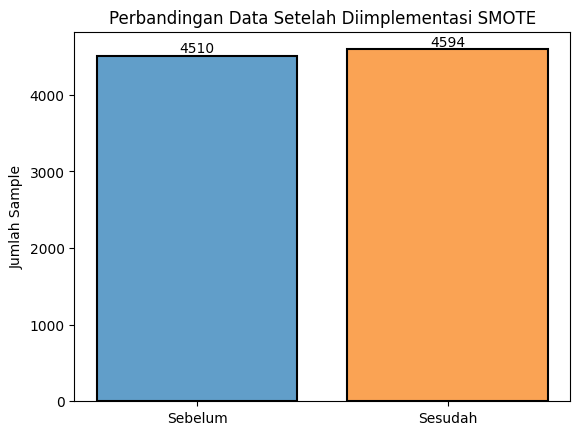

In [128]:
import matplotlib.pyplot as plt

x = ['Sebelum', 'Sesudah']
y = [len(stack_majority) + len(stack_minority), len(final_stack)]


plt.bar(x, y, color=[(0.38, 0.62, 0.79), (0.98, 0.64, 0.33)], edgecolor='black', linewidth=1.5)

for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='bottom')

plt.ylabel('Jumlah Sample')
plt.title('Perbandingan Data Setelah Diimplementasi SMOTE')

plt.show()

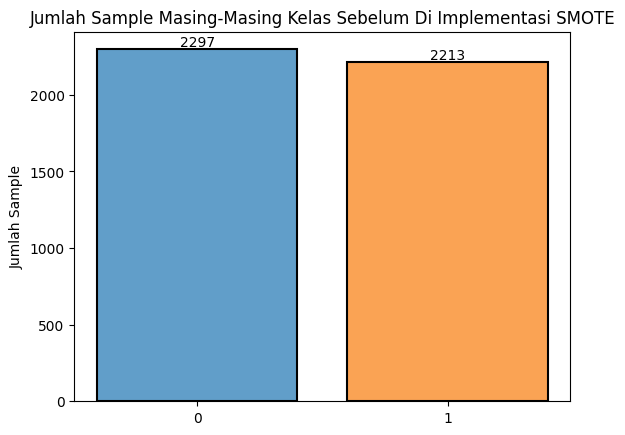

In [129]:
x = ['0', '1']
y = [df['Sarcasm'].value_counts()[0], df['Sarcasm'].value_counts()[1]]


plt.bar(x, y, color=[(0.38, 0.62, 0.79), (0.98, 0.64, 0.33)], edgecolor='black', linewidth=1.5)

for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='bottom')

plt.ylabel('Jumlah Sample')
plt.title('Jumlah Sample Masing-Masing Kelas Sebelum Di Implementasi SMOTE')

plt.show()

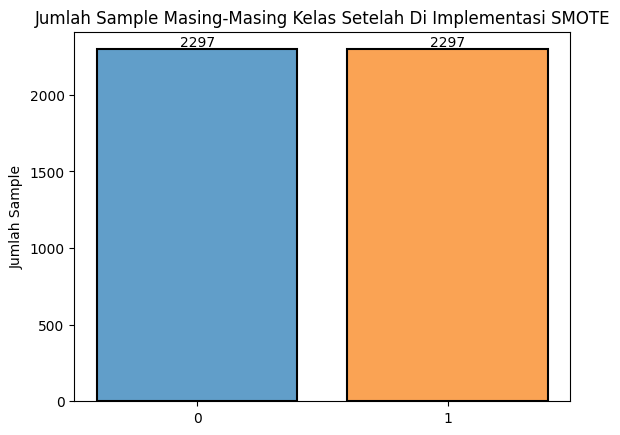

In [130]:
x = ['0', '1']
y = [result[0][1], result[1][1]]


plt.bar(x, y, color=[(0.38, 0.62, 0.79), (0.98, 0.64, 0.33)], edgecolor='black', linewidth=1.5)

for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='bottom')

plt.ylabel('Jumlah Sample')
plt.title('Jumlah Sample Masing-Masing Kelas Setelah Di Implementasi SMOTE')

plt.show()

In [ ]:
# X_embedding = np.array(df_ready['embedding'][:2]).reshape(-1, 1)
# sentiment_values = np.array(df_ready['Sentimen_Text'][:2]).reshape(-1, 1)

# num_rows = X_embedding.shape[0]

# X_sentiment = np.empty((num_rows, 1), dtype=np.str_)

# for i in range(num_rows):
#     X_sentiment[i] = sentiment_values[i % sentiment_values.shape[0]]

# X = np.hstack((X_embedding, X_sentiment))

# X

In [ ]:
# y = df_ready['Sarcasm']

# y

In [ ]:
# from sklearn.neighbors import NearestNeighbors

# def get_k_nearest_neighbors(X, sample, k):
#     # Mencari tetangga terdekat menggunakan k-NN
#     knn = NearestNeighbors(n_neighbors=k+1)
#     knn.fit(X)
    
#     # Mengembalikan indeks tetangga terdekat untuk sampel
#     _, indices = knn.kneighbors([sample])
#     indices_1d = indices.flatten()  # Mengubah menjadi 1D array
    
#     return indices_1d[1:]  # Menghilangkan indeks diri sendiri

In [ ]:
# import pandas as pd
# import numpy as np
# import math

# def SMOTE(df, k, oversampling_ratio):
#     # Mendapatkan array numpy dari fitur embedding, sentiment, dan label
#     embeddings = np.vstack(df['embedding'].to_numpy())
#     labels = df['Sarcasm'].to_numpy()
    
#     # Menginisialisasi array untuk menyimpan sampel sintetis yang dihasilkan
#     synthetic_samples = []
    
#     # Mencari indeks sampel minoritas dan mayoritas
#     minority_indices = np.where(labels == 1)[0]
#     majority_indices = np.where(labels == 0)[0]
    
#     # Menghitung jumlah sampel sintetis yang akan dibuat untuk kelas minoritas
#     num_minority_samples = len(minority_indices)
#     num_majority_samples = len(majority_indices)
    
#     num_synthetic_samples = min(num_majority_samples - num_minority_samples, math.ceil(num_minority_samples * oversampling_ratio))
    
#     if num_synthetic_samples <= 0:
#         return pd.DataFrame()  # Return empty DataFrame jika tidak ada sampel sintetis yang perlu dibuat
    
#     # Looping melalui setiap sampel minoritas
#     for i in minority_indices:
#         sample = embeddings[i]
        
#         # Mencari tetangga terdekat untuk sampel minoritas
#         neighbors = get_k_nearest_neighbors(embeddings, sample, k)
        
#         # Menghasilkan sampel sintetis
#         for j in range(num_synthetic_samples):
#             # Memilih satu tetangga acak
#             neighbor_index = np.random.choice(neighbors)
            
#             if neighbor_index >= len(embeddings):
#                 continue  # Skip jika indeks tetangga melebihi ukuran data yang valid
            
#             neighbor = embeddings[neighbor_index]
            
#             # Menghitung selisih antara sampel dan tetangga
#             diff = neighbor - sample
            
#             # Menghasilkan sampel sintetis dengan proporsi acak
#             proportion = np.random.uniform(0, 1, size=1)
#             synthetic_sample = sample + proportion * diff
            
#             # Menambahkan sampel sintetis ke array
#             synthetic_samples.append(synthetic_sample)
    
#     # Mengubah array numpy ke DataFrame
#     embedding_array = np.vstack(synthetic_samples)
#     embedding_df = pd.DataFrame(embedding_array, columns=['embedding'] * embedding_array.shape[1])
#     sarcasm_df = pd.DataFrame(np.zeros((embedding_array.shape[0], 1)), columns=['Sarcasm'])
#     synthetic_df = pd.concat([embedding_df, sarcasm_df], axis=1)
    
#     # Menambahkan label kelas minoritas pada data sintetis
#     synthetic_df['Sarcasm'] = 1

#     return synthetic_df

In [ ]:
# oversampled_df = SMOTE(df_ready, k=5, oversampling_ratio=1.0)

<h1>Training Bi-LSTM<h1>

<h2>Fungsi untuk merubah word embedding menjadi token</h2>

In [ ]:
# def replace_embedding_with_token(embeddings, word_embedding):
#     token = []
#     for value in embeddings:
#         index = np.array(value)
#         vector = tuple(index) 
#         if vector in word_embedding:
#             token.append(word_embedding[vector])
    
#     return token

In [ ]:
# df_ready['text_emoji'] = df_ready['text_emoji'].apply(replace_embedding_with_token, word_embedding=embedding2word)

In [ ]:
# df_ready['text_emoji'] = df_ready['text_emoji'].apply(lambda x: ' '.join(x))

In [ ]:
# df_ready.head(11)